<h1 style="text-align: center;">Predicting Hotel Booking Cancellations: A Strategic Approach to Improve Operations and Revenue</h1>
<h3 style="text-align: center;">By : Melin Ayu Safitri</h3>

---

## **Section 1. Business Understanding**

**1.1 Context**<br>

A hotel wants to prepare rooms for its potential customers. Based on the available records, the hotel aims to identify which customers will actually stay and which ones will cancel their bookings.

Target:

0: Booking not canceled<br>
1: Booking canceled

**1.2 Problem Statements**<br>

The hotel struggles with managing cancellations, which results in several challenges:

- **Financial Losses:** Rooms that could have been sold remain unoccupied due to cancellations, leading to revenue loss.
- **Operational Inefficiencies:** It is difficult to plan resources such as staff and room availability when cancellations happen unpredictably.
- **Resource Allocation Challenges:** The hotel faces issues like overbooking or under-staffing, negatively affecting customer satisfaction and operational efficiency.

To address these problems, the hotel needs a system that can help predict which bookings are most likely to be canceled. By anticipating cancellations, the hotel can optimize its operations, reduce costs, and improve customer satisfaction.

**1.3 Goals**<br>

Based on the challenges identified, the hotel aims to achieve the following objectives:

- **Reduce the Impact of Cancellations:** By understanding the factors leading to cancellations, the hotel can take actions to minimize financial losses and improve operational efficiency.
- **Optimize Resource Planning:** Predicting cancellations will allow the hotel to better plan for staff allocation and room availability, reducing issues like overbooking and ensuring sufficient resources.
- **Identify Key Cancellation Factors:** The hotel wants to understand which factors, such as previous cancellations, booking changes, or special requests, are most strongly associated with cancellations. This will allow the hotel to make data-driven decisions for tailoring policies to reduce cancellations.

**1.4 Analytical Approach**<br>

We will analyze the data to uncover patterns that differentiate canceled bookings from non-canceled ones.

Then, we will build a classification model to predict the probability of booking cancellations, which will help the hotel make more proactive decisions.

This model will also provide insights into the features or factors that most influence the risk of cancellation, enabling the hotel to formulate more targeted strategies.

**1.5 Metric Evaluation (Business Metric, Machine Learning Evaluation Metric)**<br>

- **Business Metric**
    - ***Cancellation Rate :*** Measures the percentage of bookings that were canceled out of total bookings.<br>
        **Relevance:** Understanding the cancellation rate helps hotels mitigate the financial impact of cancellations.

- **Machine Learning Evaluation Metric**
    - ***Type 1 Error (False Positive):*** Classifying a booking that is not canceled as canceled.

        Consequence: Unnecessary precautionary actions, such as overbooking or allocating excess resources (e.g., more staff than needed), which can negatively affect customer experience and increase operational costs.

    - ***Type 2 Error (False Negative):*** Classifying a booking that is canceled as not canceled.

        Consequence: Loss of revenue due to rooms that remain unoccupied and cannot be rebooked, leading to financial losses for the hotel.

    Based on the consequences of both types of errors, the hotel aims to reduce financial losses caused by false negatives (cancellations that the model fails to detect), while avoiding unnecessary actions that arise from false positives (e.g., overbooking or excessive staffing).

    Therefore, the model should aim to minimize type 1 errors (false positives) as much as possible, since these can lead to unnecessary costs without improving customer satisfaction.

    Key Metric:

    ROC-AUC will be the primary metric used because it provides a more holistic view of model performance across different thresholds and helps the hotel avoid both types of errors, particularly false positives. A good model is one that minimizes false positives while capturing as many false negatives as possible, to maximize revenue and customer satisfaction.


**1.6 Success Criteria**<br>
- ***Reduction in Cancellations:*** The Cancellation Rate should decrease by 10-15% within a specific period after implementing strategies based on the model's predictions.
- ***Goal:*** The hotel should be able to reduce cancellations, leading to a more stable revenue stream and better resource planning.

- ***Relevance:*** A high ROC-AUC score indicates that the model is effectively distinguishing between canceled and non-canceled bookings, leading to more accurate predictions.
- ***Goal:*** The model should achieve an ROC-AUC score ≥ 0.80.

## **Section 2. Data Understanding**

In [106]:
# import library
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Ignore Warning
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Set max columns
pd.set_option('display.max_columns', None)

**2.1 General Information**


|No | Feature | Data Type | Description|
|---|---------| --------- | -----------|
|1.|country | object | Country of origin|
|2.|market_segment | object | Market segment designation|
|3.|previous_cancellations | int64 | Number of previous bookings that were cancelled by the customer prior to the current booking|
|4.|booking_changes | int64 | Number of changes/amendments made to the booking from the moment the booking was entered on the PMS until the moment of check-in or cancellation|
|5.|deposit_type | object | Indication on if the customer made a deposit to guarantee the booking|
|6.|days_in_waiting_list | int64 | Number of days the booking was in the waiting list before it was confirmed to the customer|
|7.|customer_type | object | Type of booking|
|8.|reserved_room_type | object | Code of room type reserved. Code is presented instead of designation for anonymity reasons|
|9.|required_car_parking_space | int64 | Number of car parking spaces required by the customer|
|10.|total_of_special_request | int64 | Number of special requests made by the customer (e.g. twin bed or high floor)|
|11.|is_canceled | int64 | Value indicating if the booking was canceled (1) or not (0)|


**2.2 Feature Information**

|No.| Feature | Impact to Business |
|---|---------| ------------------ |
| 1. | country |Helps in targeting specific geographic markets with tailored marketing strategies, optimizing regional demand.|
| 2. | market_segment |Enables price optimization and cost control by understanding the distribution of bookings across different segments.|
| 3. | previous_cancellations |High cancellation rates could signal a need for better booking policies or incentives to reduce lost revenue.|
| 4. | booking_changes|Frequent changes to bookings can create operational inefficiencies, leading to higher labor costs and potential customer dissatisfaction.|
| 5. | deposit_type |Non-refundable deposits secure revenue and reduce cancellations, while refundable deposits may lead to more flexibility and customer trust.|
| 6. | days_in_waiting_list|Long waiting times can decrease customer satisfaction, leading to potential lost bookings if not addressed.|
| 7. | customer_type|Identifying customer types allows for tailored pricing and booking management strategies.|
| 8. | reserved_room_type|Accurate room type reservations ensure customer satisfaction and prevent issues with overbooking or mismatch between expectations and actual offerings.|
| 9. | required_car_parking_space|Understanding parking demand ensures sufficient availability for guests, preventing dissatisfaction from inadequate facilities.|
| 10.| total_of_special_request|Managing special requests enhances guest satisfaction but may increase operational complexity and costs.|
| 11.| is_canceled|Tracking cancellations allows for better revenue forecasting and aids in adjusting booking policies to minimize revenue loss.|


**2.3 Statistics Summary**

In [107]:
df = pd.read_csv(r'C:\Users\user\OneDrive\Documents\Hotel-Booking-Demand-Project\data\raw\data_hotel_booking_demand.csv')
df.head()

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
0,IRL,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0
1,FRA,Online TA,0,0,No Deposit,0,Transient,A,0,2,0
2,PRT,Online TA,0,1,No Deposit,0,Transient,A,0,2,0
3,NLD,Online TA,0,0,No Deposit,0,Transient,A,0,1,1
4,PRT,Online TA,0,2,No Deposit,0,Transient,A,0,2,0


In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83573 entries, 0 to 83572
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   country                      83222 non-null  object
 1   market_segment               83573 non-null  object
 2   previous_cancellations       83573 non-null  int64 
 3   booking_changes              83573 non-null  int64 
 4   deposit_type                 83573 non-null  object
 5   days_in_waiting_list         83573 non-null  int64 
 6   customer_type                83573 non-null  object
 7   reserved_room_type           83573 non-null  object
 8   required_car_parking_spaces  83573 non-null  int64 
 9   total_of_special_requests    83573 non-null  int64 
 10  is_canceled                  83573 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 7.0+ MB


**Dataset Overview:**<br>
- **Total Entries**: `83,573 rows`
- **Missing Values**: Only in `country` (351 missing values).

In [109]:
df.describe()

,previous_cancellations,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,is_canceled
count,83573.000000,83573.000000,83573.000000,83573.000000,83573.000000,83573.000000
mean,0.086798,0.220897,2.330561,0.062999,0.573211,0.368277
std,0.841011,0.648635,17.673051,0.246919,0.795163,0.482340
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,26.000000,21.000000,391.000000,8.000000,5.000000,1.000000


**Insight:**<br>
- **Median (50%): 0** → More than **50% of customers have never canceled a reservation before**.  
- **Max: 21** → Some customers made **up to 21 changes to their reservation**.  
- **Max: 391** → Some customers waited **up to 391 days for confirmation** (significant outlier).  
- **Mean: 0.06** → The **majority of customers do not require parking spaces**.  
- **Most customers do not have special requests**, but some may have specific preferences.  
- The **cancellation rate is quite significant (37%)**, requiring further analysis to identify the factors contributing to cancellations.  

In [110]:
df.describe(include='object')

,country,market_segment,deposit_type,customer_type,reserved_room_type
count,83222,83573,83573,83573,83573
unique,162,8,3,4,10
top,PRT,Online TA,No Deposit,Transient,A
freq,34097,39460,73352,62732,60041


**Insight:**<br>
- The **majority of customers are from Portugal**, indicating that the **domestic market dominates hotel reservations**.  
- The **Online Travel Agency (OTA) market segment is the primary channel for hotel reservations**, highlighting the **importance of online platforms for the hotel's business**.  
- **Freq: 73,352 → Approximately 88% of customers do not provide a deposit upfront**.  
- **Freq: 62,732 → Around 75% of customers are of the Transient type** (individual customers with short-term reservations).  

## **Section 3. Data Cleaning**

**3.1 Missing Values**

In [111]:
# Data Cleaning - Identify Missing Values
df.isnull().sum().apply(lambda x: f'{x} = ({x/len(df):.2%})')

country                        351 = (0.42%)
market_segment                   0 = (0.00%)
previous_cancellations           0 = (0.00%)
booking_changes                  0 = (0.00%)
deposit_type                     0 = (0.00%)
days_in_waiting_list             0 = (0.00%)
customer_type                    0 = (0.00%)
reserved_room_type               0 = (0.00%)
required_car_parking_spaces      0 = (0.00%)
total_of_special_requests        0 = (0.00%)
is_canceled                      0 = (0.00%)
dtype: object

**Insight:**<br>

The country column has 351 missing values, representing approximately 0.42% of the data.<br>
This is a relatively small percentage and can be addressed using methods to removing the rows.

In [112]:
# Handling Missing Values
df = df.dropna()

In [113]:
# Confirm the adjustments by checking for any remaining missing values.
df[["country"]].isna().sum().reset_index().rename(columns={"index": "column", 0: "missing values"})

,column,missing values
0,country,0


***The missing values has been successfully addressed***

**3.2 Duplicated Values**

In [114]:
# Data Cleaning - Identify Data Duplicated
print('Total Duplicated Rows: ', df.duplicated().sum())

Total Duplicated Rows:  73138


In [115]:
df[df.duplicated()]

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
7,PRT,Groups,0,0,Non Refund,0,Transient,A,0,0,1
22,PRT,Groups,0,0,Non Refund,0,Transient,A,0,0,1
29,PRT,Online TA,0,0,No Deposit,0,Transient,A,0,1,0
34,PRT,Groups,0,0,Non Refund,0,Transient,A,0,0,1
44,PRT,Groups,0,0,Non Refund,0,Transient,A,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
83568,PRT,Online TA,0,0,No Deposit,0,Contract,A,0,3,1
83569,FRA,Online TA,0,0,No Deposit,0,Transient,D,0,2,0
83570,PRT,Online TA,0,1,No Deposit,0,Transient,D,0,3,0
83571,CN,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0


In [116]:
df[(df['country'] == 'PRT') & (df['customer_type'] == 'Contract') & (df['deposit_type'] == 'No Deposit') & (df['market_segment'] == 'Groups')]

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
151,PRT,Groups,1,0,No Deposit,0,Contract,A,0,0,1
189,PRT,Groups,1,0,No Deposit,0,Contract,A,0,0,1
2450,PRT,Groups,1,0,No Deposit,0,Contract,A,0,0,1
3060,PRT,Groups,1,0,No Deposit,0,Contract,A,0,0,1
3626,PRT,Groups,1,0,No Deposit,0,Contract,A,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
80541,PRT,Groups,1,0,No Deposit,0,Contract,A,0,0,1
82066,PRT,Groups,1,0,No Deposit,0,Contract,A,0,0,1
82790,PRT,Groups,1,0,No Deposit,0,Contract,A,0,0,1
83099,PRT,Groups,1,0,No Deposit,0,Contract,A,0,0,1


**Insight:**<br>

It can be seen that the description of each column above proves that the data values are truly duplicates across all columns, and therefore, it requires handling. This is because duplicate data causes redundancy, which does not add any value to the analysis, and machine learning models can become biased if the same data is repeated multiple times.

In [117]:
# Handling Data Duplicated
df.drop_duplicates(inplace=True)

In [118]:
# Verifying duplicates, since each listing should have a distinct identifier
df.duplicated().sum()

np.int64(0)

***I have verified that the dataset contains no duplicate entries.***

**3.3 Identify Spelling Errors**

In [119]:
# Categoric Variable

categoric_features = df.select_dtypes('object')

for col in categoric_features.columns:
    print(f"Total category on '{col}': {df[col].nunique()}")

Total category on 'country': 162
Total category on 'market_segment': 8
Total category on 'deposit_type': 3
Total category on 'customer_type': 4
Total category on 'reserved_room_type': 10


In [120]:
for col in categoric_features.columns:
    print(f"Column: {col}")
    print(df[col].value_counts())
    print()

Column: country
country
PRT    1993
GBR     734
ESP     641
FRA     612
DEU     432
       ... 
DMA       1
KIR       1
MYT       1
KNA       1
AIA       1
Name: count, Length: 162, dtype: int64

Column: market_segment
market_segment
Online TA        4924
Direct           2079
Offline TA/TO    1469
Groups            845
Corporate         505
Complementary     180
Aviation           81
Undefined           1
Name: count, dtype: int64

Column: deposit_type
deposit_type
No Deposit    9843
Non Refund     194
Refundable      47
Name: count, dtype: int64

Column: customer_type
customer_type
Transient          6813
Transient-Party    2549
Contract            481
Group               241
Name: count, dtype: int64

Column: reserved_room_type
reserved_room_type
A    4562
D    2025
E    1248
F     715
G     546
B     454
C     339
H     192
L       2
P       1
Name: count, dtype: int64



The fact that **no spelling errors were found** indicates that the dataset is well-maintained, with clean and reliable text entries.

**3.4 Identify Anomaly Values**

- Check Distribution (Numerical Variable)

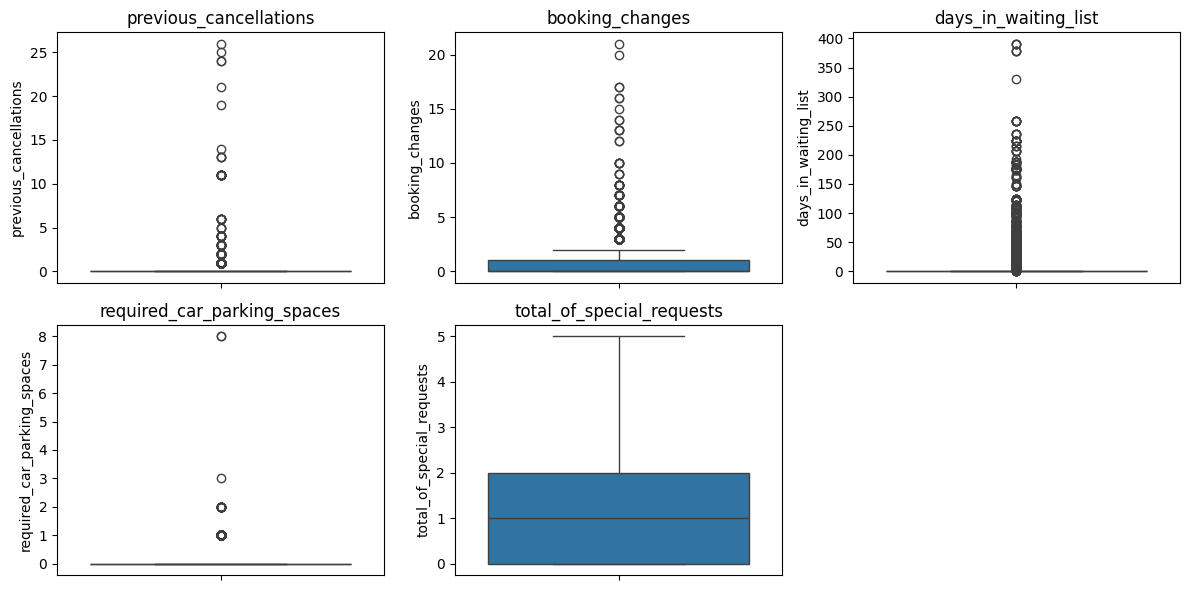

In [121]:
# Identify Numeric Distribution
num_features=df.drop(['country','market_segment','deposit_type','customer_type',
                      'reserved_room_type', 'is_canceled'],axis=1)

plt.figure(figsize=(12,6))
for idx,feature in enumerate(num_features.columns, start=1):
    sns.boxplot(df[feature], ax=plt.subplot(2,3,idx))
    plt.subplot(2,3,idx).set_title(feature)
plt.tight_layout()
plt.show()

**Insight:**<br>

From the descriptive statistics previously performed, there are extreme outliers in the **`days_in_waiting_list`** variable. In the context of hotel reservations or similar services, waiting for more than **300 days** for confirmation is highly unrealistic and can lead to distortions in statistical analysis and model outcomes.

To address this issue, we will remove these outlier data points. This is because machine learning models can become **biased** if very rare or unrealistic data points are left in the dataset. This can lead to **overfitting**, where the model becomes overly focused on cases that do not represent the majority of the data and performs poorly on other data.

- Handling Anomaly Values

In [122]:
(df['days_in_waiting_list'] >= 300).sum()

np.int64(7)

7 outliers from 10,084 rows represent approximately 0.07% of the total data.

In [123]:
# So, drop rows where the value of `days_in_waiting_list` is greater than 300
df = df.drop(df[df['days_in_waiting_list'] > 300].index)


In [124]:
(df['days_in_waiting_list'] >= 300).sum()

np.int64(0)

***The outlier data has been successfully removed.***

- Check Cardinality (Categorical Variable)

In [125]:
# Identify Categorical Distribution
cat_features=df[['country','market_segment','deposit_type','customer_type',
                 'reserved_room_type']]

for feature in cat_features.columns:
    print (f'total unique values({feature}): {df[feature].nunique()}')
    print(df[feature].value_counts(normalize=True))
    print("")

total unique values(country): 162
country
PRT    0.197380
GBR    0.072839
ESP    0.063610
FRA    0.060435
DEU    0.042870
         ...   
DMA    0.000099
KIR    0.000099
MYT    0.000099
KNA    0.000099
AIA    0.000099
Name: proportion, Length: 162, dtype: float64

total unique values(market_segment): 8
market_segment
Online TA        0.488637
Direct           0.206311
Offline TA/TO    0.145778
Groups           0.083160
Corporate        0.050114
Complementary    0.017862
Aviation         0.008038
Undefined        0.000099
Name: proportion, dtype: float64

total unique values(deposit_type): 3
deposit_type
No Deposit    0.976382
Non Refund    0.018954
Refundable    0.004664
Name: proportion, dtype: float64

total unique values(customer_type): 4
customer_type
Transient          0.675796
Transient-Party    0.252555
Contract           0.047732
Group              0.023916
Name: proportion, dtype: float64

total unique values(reserved_room_type): 10
reserved_room_type
A    0.452019
D    0.2009

In [126]:
# Data Cleaning - Identify Target Distribution
df['is_canceled'].value_counts().apply(lambda x: f'{x} = {(x/len(df)):.1%}')

is_canceled
0    7685 = 76.3%
1    2392 = 23.7%
Name: count, dtype: object

**Insight :** <br>

This data is considered **imbalanced** because the distribution of the **`is_canceled`** variable is not even. The majority of the data (76.3%) represents **non-canceled reservations (0)**, while only 23.7% represents **canceled reservations (1)**.

Since the number of data points in class **`0`** is much higher, the model is likely to predict class **`0`** more often, which can lead to **bias** and **poor performance** in predicting class **`1`**. This makes the model less effective at handling cases where the minority class (cancellations) is more important.

In [127]:
df.to_csv('clean_dataset.csv')

## **Section 4. Data Generation**

In [128]:
from sklearn.model_selection import train_test_split

**4.1 Constructing `Seen` and `Unseen` Data**

In [129]:
# Define feature and target
feature_seen = df.drop('is_canceled', axis=1)
target_seen = df['is_canceled']

**4.2 Constructing `Training` and `Testing` Data (from `Seen` Dataset)**

In [130]:
# Split data into Seen (80%) and Unseen (20%)
df_seen, df_unseen = train_test_split(df, test_size=0.2, random_state=42, stratify= target_seen) 

In [131]:
# Check the shape of each dataset
print("Shape of seen dataset:", df_seen.shape)
print("Shape of unseen dataset:", df_unseen.shape)

Shape of seen dataset: (8061, 11)
Shape of unseen dataset: (2016, 11)


## **Section 5. Exploratory Data Analysis (EDA)**

**5.1 Check Correlation**

In [132]:
df_seen.corr(numeric_only=True)

,previous_cancellations,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,is_canceled
previous_cancellations,1.000000,-0.045691,-0.008174,-0.018970,-0.012111,0.068511
booking_changes,-0.045691,1.000000,-0.027156,-0.009095,-0.007807,-0.069715
days_in_waiting_list,-0.008174,-0.027156,1.000000,-0.053255,-0.124549,0.024936
required_car_parking_spaces,-0.018970,-0.009095,-0.053255,1.000000,0.029895,-0.235913
total_of_special_requests,-0.012111,-0.007807,-0.124549,0.029895,1.000000,-0.070752
is_canceled,0.068511,-0.069715,0.024936,-0.235913,-0.070752,1.000000


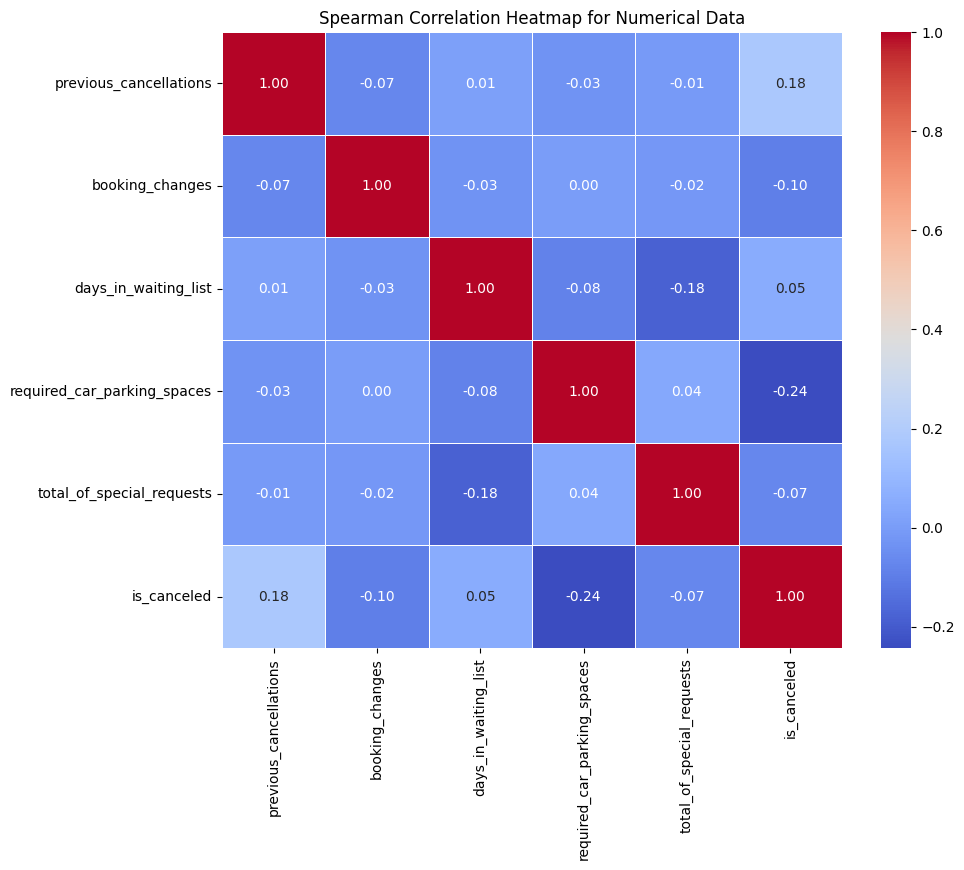

In [133]:
# Filter for numerical columns
numerical_data = df_seen.select_dtypes(include=['number'])

# Calculate the Spearman correlation matrix
correlation_matrix = numerical_data.corr(method='spearman')

# Create a heatmap
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Spearman Correlation Heatmap for Numerical Data')
plt.show()

**Insight:**<br>

Previous Cancellations and Is Canceled: A moderate positive correlation (0.18) is observed.<br>
This suggests that guests with a history of cancellations are more likely to cancel future bookings.

**5.2 Barplot**

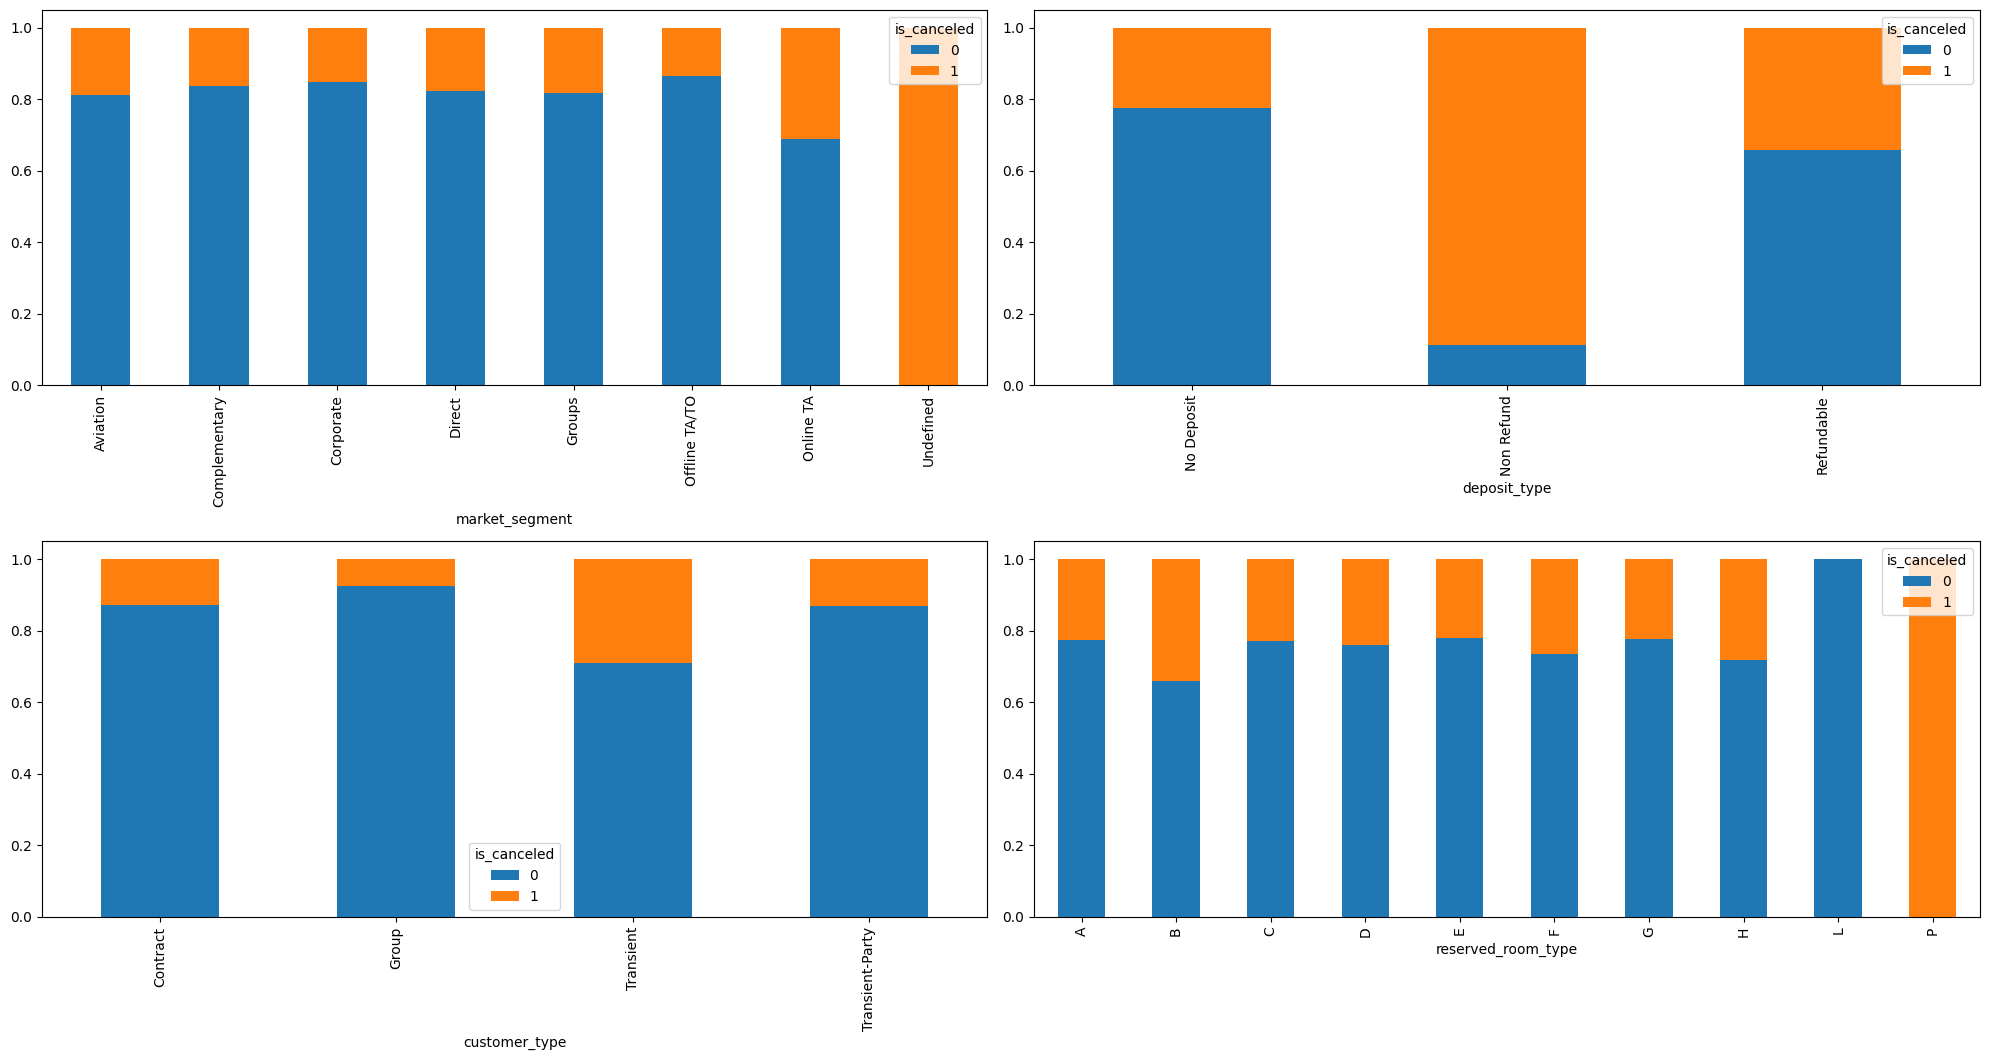

In [134]:
count = 0
fig = plt.figure(figsize=(20,20))

for i in df_seen.drop(columns=['is_canceled','country','previous_cancellations','booking_changes','days_in_waiting_list','required_car_parking_spaces','total_of_special_requests']).columns:
    count +=1
    ax= plt.subplot(4,2,count)
    pd.crosstab(df_seen[i],df_seen['is_canceled'],normalize=0).plot(kind='bar',stacked=True,ax=ax)
    fig.tight_layout()

plt.show()

**Based on visualization above, it can be concluded that:** 

- There is a relationship between certain variables and the cancellation rate. Some market segments, deposit types, customer types, and room types have higher cancellation rates compared to others.  
- This information can be used to identify areas that need improvement. For example, hotels can focus on customer retention strategies for segments with high cancellation rates or adjust deposit policies to reduce cancellations.

In [135]:
for i in df_seen.drop(columns=['is_canceled','country','previous_cancellations','booking_changes','days_in_waiting_list','required_car_parking_spaces','total_of_special_requests']).columns:
    market_segment_df = df_seen.groupby(i)['is_canceled'].value_counts(normalize=True).unstack()
    display(market_segment_df.sort_values(by=[1.0], ascending=False))

is_canceled,0,1
market_segment,,
Undefined,NaN,1.000000
Online TA,0.687011,0.312989
Aviation,0.811594,0.188406
Groups,0.816265,0.183735
Direct,0.821668,0.178332
Complementary,0.836879,0.163121
Corporate,0.846914,0.153086
Offline TA/TO,0.865303,0.134697


is_canceled,0,1
deposit_type,,
Non Refund,0.111842,0.888158
Refundable,0.657895,0.342105
No Deposit,0.775759,0.224241


is_canceled,0,1
customer_type,,
Transient,0.709392,0.290608
Transient-Party,0.868008,0.131992
Contract,0.870558,0.129442
Group,0.924623,0.075377


is_canceled,0,1
reserved_room_type,,
P,NaN,1.000000
B,0.659574,0.340426
H,0.717105,0.282895
F,0.735294,0.264706
D,0.759293,0.240707
C,0.771863,0.228137
A,0.774469,0.225531
G,0.775982,0.224018
E,0.779575,0.220425


**Insight :**<br>

- ***Market Segment:*** OTA and Undefined market segments have high cancellation rates.
- ***Deposit Type:*** Non-refundable deposits have a higher chance of cancellations.
- ***Customer Type:*** Transient customers are more prone to cancel.
- ***Reserved Room Type:*** Room types L and P have disproportionately higher cancellation rates.

Text(0.5, 0, 'Is Canceled Status')

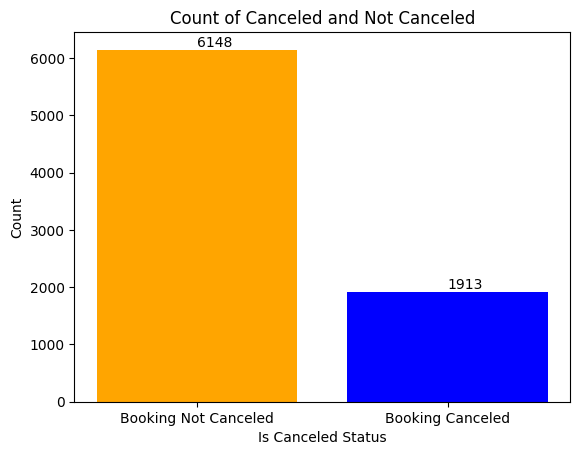

In [136]:
# Updated categories and counts
categories = ['Booking Not Canceled', 'Booking Canceled']
counts = df_seen['is_canceled'].value_counts()

# Generating the updated bar chart
fig, ax = plt.subplots()
bars = ax.bar(categories, counts, color=['orange', 'blue'])

# Adding the count above the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom')  

# Setting the title and labels
ax.set_title('Count of Canceled and Not Canceled')
ax.set_ylabel('Count')
ax.set_xlabel('Is Canceled Status')

**Insight:**

- ***High Retention Rate:*** The significantly higher count of `Booking Not Canceled` suggests a relatively high retention rate for bookings. This could indicate that the hotel is doing a good job in retaining guests and minimizing cancellations.

- ***Potential for Improvement:*** While the retention rate is high, there is still a considerable number of cancellations. Analyzing the factors contributing to these cancellations (as shown in the visualization) could help identify areas for improvement in booking policies, customer service, or other aspects of the hotel's operations.

**5.3 Normality Test**

In [137]:
from scipy.stats import shapiro

numerical_columns = df_seen.select_dtypes(include=["int64", "float64"]).columns

normality_test_results = {}

num_cols = len(numerical_columns)

rows = (num_cols + 2) // 3

for i, col in enumerate(numerical_columns):

    # Perform the Shapiro-Wilk Test for normality
    shapiro_test = shapiro(df_seen[col])  # Use shapiro directly

    # Calculate the skewness
    skewness = df[col].skew()

    # Determine the skew direction
    if skewness > 0:
        skew_direction = "Positive"
    elif skewness < 0:
        skew_direction = "Negative"
    else:
        skew_direction = "None"

    # Storing the results
    normality_test_results[col] = {
        "Shapiro-Wilk Statistic": shapiro_test.statistic,
        "Shapiro-Wilk p-value": shapiro_test.pvalue,
        "Skewness": skewness,
        "Skew Direction": skew_direction
    }

# Convert the dictionary to a DataFrame
normality_results_df = pd.DataFrame(normality_test_results).T

# Adding a column to indicate if the data is normally distributed based on p-values
normality_results_df["Normally Distributed"] = (normality_results_df["Shapiro-Wilk p-value"] > 0.05)

normality_results_df

,Shapiro-Wilk Statistic,Shapiro-Wilk p-value,Skewness,Skew Direction,Normally Distributed
previous_cancellations,0.08674,0.0,18.849286,Positive,False
booking_changes,0.629617,0.0,3.745516,Positive,False
days_in_waiting_list,0.157677,0.0,7.84598,Positive,False
required_car_parking_spaces,0.434923,0.0,3.302156,Positive,False
total_of_special_requests,0.817682,0.0,0.981649,Positive,False
is_canceled,0.527404,0.0,1.234707,Positive,False


## **Section 6. Data Preparation**

**6.1 Initialization**

- Initialization function

In [138]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
import category_encoders as ce
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.pipeline import Pipeline

- Define Feature and Target

In [139]:
# define feature and target

feature = df_seen.drop('is_canceled', axis=1)
target = df_seen['is_canceled']

In [140]:
X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size=0.2,
                                                    random_state=42, stratify=target)
print(X_train.shape)
print(y_train.shape)

(6448, 10)
(6448,)


In [141]:
df_seen.head()

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
29711,CN,Online TA,0,0,No Deposit,0,Transient,F,0,2,0
52006,GBR,Groups,0,1,No Deposit,113,Transient-Party,A,0,0,0
32784,ESP,Online TA,0,0,No Deposit,0,Transient,F,0,2,0
54581,PRT,Corporate,1,1,No Deposit,0,Transient,A,0,0,0
150,POL,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0


By adjusting the skewness values during the EDA phase, we can determine whether numerical columns should undergo **Binning** or **Scaling**. Here’s what we will do:

1. Perform **Binning** on the `previous cancellations` column, where **0** indicates no previous cancellations and **1** indicates previous cancellations. This is because the skewness value of this column is extremely high at **18.8**, indicating a highly positive skew, making it unsuitable for **Scaling**.  

2. Perform **Binning** on the `booking changes` column, where **0** indicates no booking changes and **1** indicates booking changes. The skewness value is also highly positive at **3.7**, making it unsuitable for **Scaling**.  

3. Perform **Binning** on the `days in waiting list` column, where **0** indicates not on the waiting list and **1** indicates being on the waiting list. This column also shows a highly positive skew with a value of **7.8**.  

4. Perform **Binning** on the `required_car_parking_spaces` column, where **0** indicates no parking space requested and **1** indicates parking space requested. The skewness value here is **3.3**, indicating a highly positive skew, and there are extreme outliers in this column, making it unsuitable for **Scaling**.  

5. Perform **Scaling** on the `total_of_special_requests` column because it shows only a slight skewness of **0.9** and does not contain extreme outliers in its values. Using **MinMax Scaling** because the values haven't been extreme outliers.

Now let’s perform **feature encoding** for the categorical features we have. Here’s what we’ll do:

1. **Transform the `country` column using Binary Encoding:**  
   The `country` column contains many unique values and has no inherent order (it’s not ordinal). If we use **One-Hot Encoding**, it will create too many new features, and using **Ordinal/Label Encoding** might not produce meaningful results. Therefore, **Binary Encoding** is a more suitable choice to efficiently represent this feature without introducing unnecessary complexity.

2. **Transform the `market_segment` column using One-Hot Encoding:**  
   This column contains different market segment types (e.g., Corporate, Direct, Online, etc.). These segment types do not have any clear order or numerical relationship, making **One-Hot Encoding** the most appropriate choice. Each segment will be converted into a binary dummy variable that can be processed by machine learning models without implying any incorrect ordinal meaning.

3. **Transform the `deposit_type` column using One-Hot Encoding:**  
   The `deposit_type` column contains information about deposit types (e.g., No Deposit, Non-Refund, and Refundable). Although there are only three categories, there is no numerical order between them. **One-Hot Encoding** is the better choice because it accurately represents each deposit type without introducing a misleading ordinal relationship.

4. **Transform the `customer_type` column using One-Hot Encoding:**  
   This column indicates customer types (e.g., Transient, Contract, Group). Similar to `market_segment`, it has no inherent order or numerical meaning. Therefore, **One-Hot Encoding** is the appropriate choice, allowing each customer type to be represented without suggesting any ordinal or numerical relationship.

5. **Transform the `reserved_room_type` column using One-Hot Encoding:**  
   This column represents the type of room reserved (e.g., A, B, C, etc.). Since these categories have no clear numerical order and each room type has a distinct meaning, **One-Hot Encoding** will convert each room type into a binary column, ensuring that the model does not assume any ordinal relationship between them.

**6.2 Data Transformation (Feature Engineering)**

In [142]:
# binning
df_seen['previous_cancellations'] = df_seen['previous_cancellations'].apply(lambda x: 0 if x == 0 else 1)
df_seen['booking_changes'] = df_seen['booking_changes'].apply(lambda x: 0 if x == 0 else 1)
df_seen['days_in_waiting_list'] = df_seen['days_in_waiting_list'].apply(lambda x: 0 if x == 0 else 1)
df_seen['required_car_parking_spaces'] = df_seen['required_car_parking_spaces'].apply(lambda x: 0 if x == 0 else 1)

# Create transformer object
transformer = ColumnTransformer(
    transformers=[
        ('scaling_minmax', MinMaxScaler(), ['total_of_special_requests']),
        ('encoding_ohe', OneHotEncoder(drop='first', handle_unknown='ignore'), ['market_segment', 'deposit_type', 'customer_type', 'reserved_room_type']),
        ('binary', ce.BinaryEncoder(), ['country'])
    ], 
    remainder='passthrough', 
    verbose_feature_names_out=False
)

**6.3 Overview**

In [143]:
# transformer 
transformer.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('scaling_minmax', MinMaxScaler(),
                                 ['total_of_special_requests']),
                                ('encoding_ohe',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore'),
                                 ['market_segment', 'deposit_type',
                                  'customer_type', 'reserved_room_type']),
                                ('binary', BinaryEncoder(), ['country'])],
                  verbose_feature_names_out=False)

In [144]:
X_train_pre = transformer.transform(X_train)
X_test_pre = transformer.transform(X_test)

# DataFrame
X_train_pre = pd.DataFrame(X_train_pre, columns=transformer.get_feature_names_out())
X_test_pre = pd.DataFrame(X_test_pre, columns=transformer.get_feature_names_out())

In [145]:
X_train_pre

,total_of_special_requests,market_segment_Complementary,market_segment_Corporate,market_segment_Direct,market_segment_Groups,market_segment_Offline TA/TO,market_segment_Online TA,market_segment_Undefined,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,reserved_room_type_H,reserved_room_type_L,country_0,country_1,country_2,country_3,country_4,country_5,country_6,country_7,previous_cancellations,booking_changes,days_in_waiting_list,required_car_parking_spaces
0,0.4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.6,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,75.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6443,0.4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
6444,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
6445,0.2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,96.0,0.0
6446,0.2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


## **Section 7. Model Development**

**7.1 Initialization**

- Initialization Function

In [146]:
# Model Selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.metrics import roc_curve, roc_auc_score

- Create Custome Metrics

- Create a workflow of the experiment

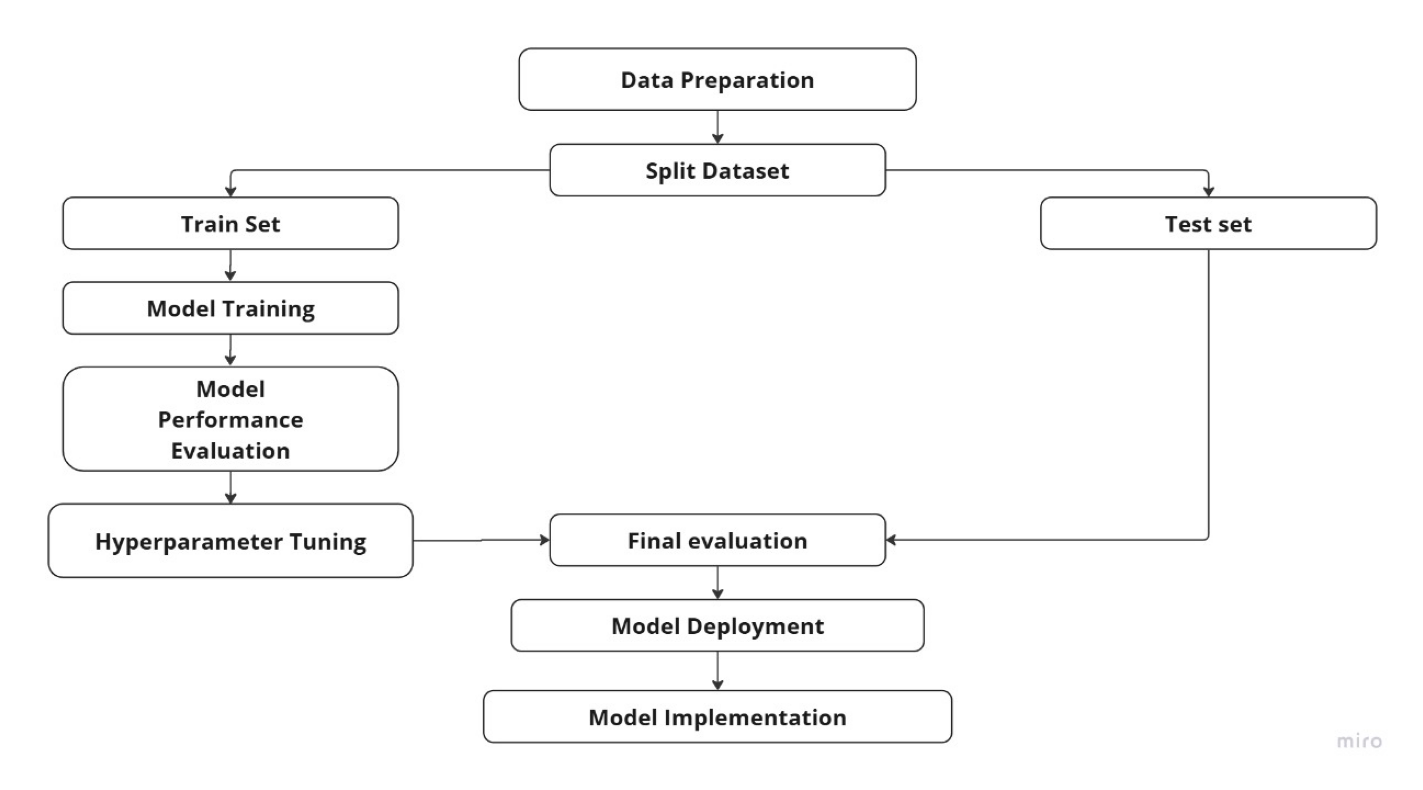

In [147]:
# Load and display an image
plt.figure(figsize=(20, 10))
img = mpimg.imread(r'C:\Users\user\OneDrive\Documents\Hotel-Booking-Demand-Project\assets\Flowchart.jpg')
plt.imshow(img)
plt.axis('off')  
plt.show()

**7.2 Developing the Model Pipeline**

In [148]:
# Create base pipeline

base_clf = Pipeline(steps=[
    ('FeatureEngineering', transformer),
    ('Classifier', None)
])

base_bal_clf = Pipeline(steps=[
    ('FeatureEngineering', transformer),
    ('Resampling', None),
    ('Classifier', None)
])

In [149]:
logreg = LogisticRegression(random_state=42)
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)
lgbm = lgb.LGBMClassifier(random_state=42)

list_model = [logreg, knn, dt, rf, xgb, lgbm]

**7.3 Model Benchmarking (Comparing model base performance)**

In [150]:
# without resample

benchmark = GridSearchCV(
    estimator=base_clf,
    param_grid={'Classifier': list_model},
    scoring=['precision', 'recall', 'roc_auc'],
    refit='roc_auc', # if scoring just 1 without refit
    cv=StratifiedKFold(shuffle=True, random_state=42),
    return_train_score=True,
    verbose=1
)

In [151]:
# benchmark process
benchmark.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[LightGBM] [Info] Number of positive: 1224, number of negative: 3934
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000652 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 134
[LightGBM] [Info] Number of data points in the train set: 5158, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.237301 -> initscore=-1.167533
[LightGBM] [Info] Start training from score -1.167533
[LightGBM] [Info] Number of positive: 1224, number of negative: 3934
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000324 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 136
[LightGBM] [Info] Number of data points in the train set: 

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('FeatureEngineering',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scaling_minmax',
                                                                         MinMaxScaler(),
                                                                         ['total_of_special_requests']),
                                                                        ('encoding_ohe',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['market_segment',
                                                                          'deposit_type',
                                                                          'custome...
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=42, ...),
                                        LGBMClassifier(random_state=42)]},
             refit='roc_auc', return_train_score=True,
             scoring=['precision', 'recall', 'roc_auc'], verbose=1)

In [152]:
benchmark.best_score_

np.float64(0.8260275235623917)

In [153]:
pd.DataFrame(benchmark.cv_results_).T

,0,1,2,3,4,5
mean_fit_time,0.067594,0.027994,0.035079,0.383707,0.084525,0.087005
std_fit_time,0.030411,0.004414,0.008844,0.015755,0.007862,0.008744
mean_score_time,0.020822,0.06016,0.020542,0.054119,0.026683,0.028629
std_score_time,0.00533,0.011992,0.002754,0.006357,0.00139,0.001376
param_Classifier,LogisticRegression(random_state=42),KNeighborsClassifier(),DecisionTreeClassifier(random_state=42),RandomForestClassifier(random_state=42),"XGBClassifier(base_score=None, booster=None, c...",LGBMClassifier(random_state=42)
params,{'Classifier': LogisticRegression(random_state...,{'Classifier': KNeighborsClassifier()},{'Classifier': DecisionTreeClassifier(random_s...,{'Classifier': RandomForestClassifier(random_s...,"{'Classifier': XGBClassifier(base_score=None, ...",{'Classifier': LGBMClassifier(random_state=42)}
split0_test_precision,0.553571,0.44856,0.355072,0.389105,0.590476,0.57971
split1_test_precision,0.606838,0.399142,0.321799,0.378182,0.51073,0.519417
split2_test_precision,0.616071,0.395062,0.318182,0.338182,0.515837,0.547264
split3_test_precision,0.536585,0.35122,0.292135,0.342105,0.538922,0.60241


In [154]:
from imblearn.under_sampling import RandomUnderSampler, NearMiss

# with resample

benchmark_resample = GridSearchCV(
    estimator=base_bal_clf,
    param_grid={'Resampling' : [SMOTE(random_state=42), 
                              RandomOverSampler(random_state=42),
                              RandomUnderSampler(random_state=42),
                              NearMiss(version=1)],
                'Classifier': list_model},
    scoring = ['precision', 'recall', 'roc_auc'],
    refit='roc_auc',
    cv=StratifiedKFold(shuffle=True, random_state=42),
    return_train_score=True,
    verbose=1,
)

In [155]:
benchmark_resample.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[LightGBM] [Info] Number of positive: 3934, number of negative: 3934
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000697 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1711
[LightGBM] [Info] Number of data points in the train set: 7868, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 3934, number of negative: 3934
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000765 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1834
[LightGBM] [Info] Number of data points in the train set: 7868, number of used features: 30
[LightGBM] [Info]

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('FeatureEngineering',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scaling_minmax',
                                                                         MinMaxScaler(),
                                                                         ['total_of_special_requests']),
                                                                        ('encoding_ohe',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['market_segment',
                                                                          'deposit_type',
                                                                          'custome...
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=42, ...),
                                        LGBMClassifier(random_state=42)],
                         'Resampling': [SMOTE(random_state=42),
                                        RandomOverSampler(random_state=42),
                                        RandomUnderSampler(random_state=42),
                                        NearMiss()]},
             refit='roc_auc', return_train_score=True,
             scoring=['precision', 'recall', 'roc_auc'], verbose=1)

In [156]:
benchmark_resample.best_score_

np.float64(0.8282977932493605)

In [157]:
pd.DataFrame(benchmark_resample.cv_results_).sort_values('rank_test_roc_auc')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_Classifier,param_Resampling,params,split0_test_precision,split1_test_precision,split2_test_precision,split3_test_precision,split4_test_precision,mean_test_precision,std_test_precision,rank_test_precision,split0_train_precision,split1_train_precision,split2_train_precision,split3_train_precision,split4_train_precision,mean_train_precision,std_train_precision,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,mean_test_recall,std_test_recall,rank_test_recall,split0_train_recall,split1_train_recall,split2_train_recall,split3_train_recall,split4_train_recall,mean_train_recall,std_train_recall,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,split0_train_roc_auc,split1_train_roc_auc,split2_train_roc_auc,split3_train_roc_auc,split4_train_roc_auc,mean_train_roc_auc,std_train_roc_auc
20,0.180849,0.009537,0.031112,0.002112,LGBMClassifier(random_state=42),SMOTE(random_state=42),{'Classifier': LGBMClassifier(random_state=42)...,0.575342,0.503205,0.518900,0.508333,0.531835,0.527523,0.025843,1,0.670505,0.671944,0.668142,0.684932,0.684163,0.675937,0.007138,0.549020,0.513072,0.493464,0.398693,0.464052,0.483660,0.050669,16,0.618464,0.624183,0.616830,0.612745,0.617647,0.617974,0.003676,0.844080,0.827872,0.832629,0.818400,0.818508,0.828298,0.009611,1,0.906112,0.905715,0.904885,0.906531,0.907807,0.906210,0.000966
21,0.112487,0.008167,0.029969,0.001181,LGBMClassifier(random_state=42),RandomOverSampler(random_state=42),{'Classifier': LGBMClassifier(random_state=42)...,0.469231,0.439502,0.458410,0.442043,0.450098,0.451857,0.010926,3,0.533962,0.526952,0.529795,0.532954,0.521918,0.529116,0.004363,0.797386,0.807190,0.810458,0.735294,0.751634,0.780392,0.030892,5,0.924837,0.926471,0.929739,0.918301,0.933824,0.926634,0.005177,0.837506,0.821859,0.828669,0.816967,0.819071,0.824814,0.007473,2,0.910864,0.908166,0.906864,0.909965,0.906771,0.908526,0.001644
16,0.199399,0.010085,0.029240,0.000969,"XGBClassifier(base_score=None, booster=None, c...",SMOTE(random_state=42),"{'Classifier': XGBClassifier(base_score=None, ...",0.527132,0.514286,0.535581,0.490741,0.522634,0.518075,0.015302,2,0.718688,0.708008,0.705769,0.717112,0.709552,0.711826,0.005128,0.444444,0.470588,0.467320,0.346405,0.415033,0.428758,0.045724,19,0.590686,0.592320,0.599673,0.592320,0.594771,0.593954,0.003143,0.832679,0.824310,0.824283,0.815085,0.814550,0.822181,0.006749,3,0.914954,0.913226,0.915613,0.917384,0.916252,0.915486,0.001385
22,0.112920,0.024255,0.031145,0.002713,LGBMClassifier(random_state=42),RandomUnderSampler(random_state=42),{'Classifier': LGBMClassifier(random_state=42)...,0.439597,0.443281,0.430508,0.419689,0.433155,0.433246,0.008153,6,0.488220,0.492056,0.486927,0.476923,0.497155,0.488256,0.006691,0.856209,0.830065,0.830065,0.794118,0.794118,0.820915,0.023872,1,0.914216,0.910948,0.928105,0.937092,0.928105,0.923693,0.009703,0.831429,0.815135,0.814838,0.803360,0.818805,0.816713,0.009003,4,0.881462,0.883555,0.882415,0.881805,0.886780,0.883204,0.001925
17,0.112347,0.007197,0.030564,0.000765,"XGBClassifier(base_score=None, booster=None, c...",RandomOverSampler(random_state=42),"{'Classifier': XGBClassifier(base_score=None, ...",0.461538,0.447266,0.448743,0.453061,0.447581,0.451638,0.005367,4,0.561108,0.564700,0.557777,0.557474,0.549905,0.558193,0.004904,0.764706,0.748366,0.758170,0.725490,0.725490,0.744444,0.016327,7,0.926471,0.930556,0.934641,0.923203,0.945261,0.932026,0.007654,0.829830,0.812635,0.819768,0.811162,0.806383,0.815956,0.008157,5,0.921634,0.926664,0.921004,0.919699,0.921473,0.922095,0.002383
18,0.098538,0.009020,0.030347,0.001390,"XGBClassifier(base_score=None, booster=None, c...",RandomUnderSampler(random_state=42),"{'Classifier': XGBClassifier(base_score=None, ...",0.439316,0.432862,0.429577,0.439068,0.440072,0.436179,0.004193,5,0.500000,0.496028,0.501552,0.4847

In [158]:
# save model

import pickle

best_model_without_resample = benchmark.best_estimator_
best_model_with_resample = benchmark_resample.best_estimator_

pickle.dump(best_model_with_resample, open('LGBM-v1-0828.sav', 'wb')) # wb = write binary
pickle.dump(best_model_without_resample, open('LGBM_v1_0826.sav', 'wb'))

**The decision to make the best model for the next step:**
- Model with resampling has a better performance score (0.828) compared to the model without resampling (0.826).
- A small improvement (0.002) could be significant when working with imbalanced datasets, where the model with resampling is more likely to provide more reliable predictions across all classes.
- Resampling helps the model better capture patterns in the minority class, improving generalization and preventing bias towards the majority class, which leads to more reliable predictions.

**7.4 Tune Model**

***References :***

1. https://lightgbm.readthedocs.io/en/latest/Parameters.html
2. https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html

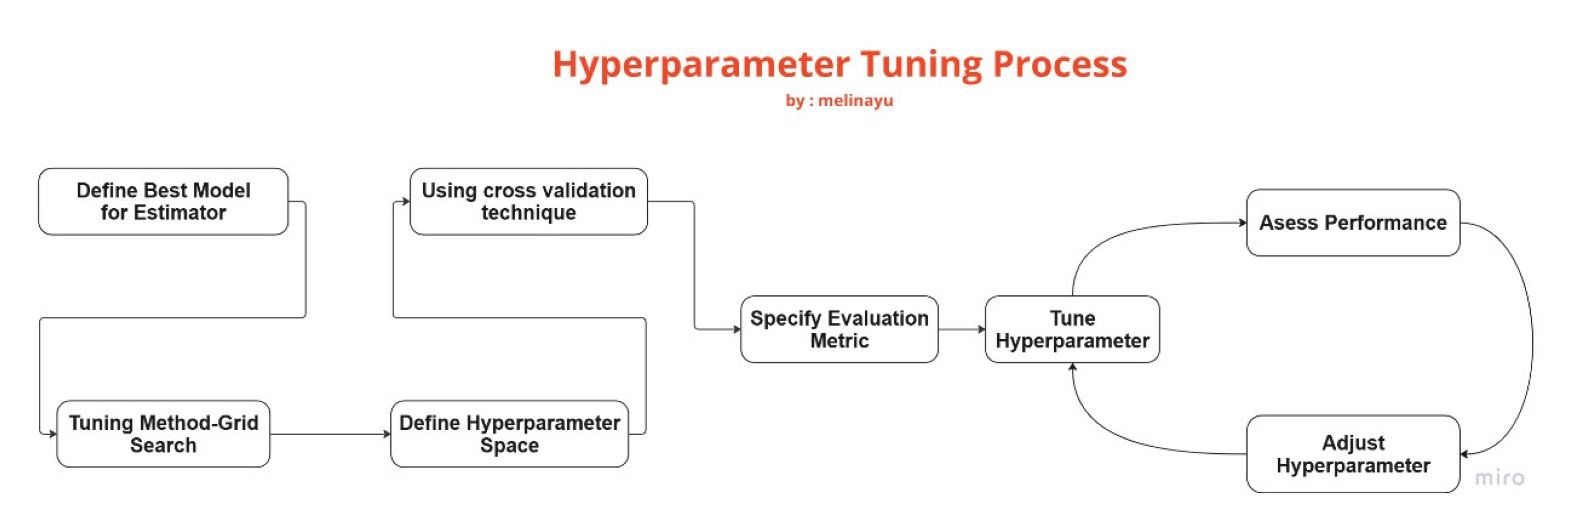

In [195]:
# Load and display an image - Hyperparameter Tuning Process
plt.figure(figsize=(20, 10))
img = mpimg.imread(r'C:\Users\user\OneDrive\Documents\Hotel-Booking-Demand-Project\assets\hyperparameter.jpg')
plt.imshow(img)
plt.axis('off')  
plt.show()

In [159]:
# Display Best Model
model = pickle.load(open('LGBM-v1-0828.sav', 'rb')) # rb = read binary

In [160]:
model

Pipeline(steps=[('FeatureEngineering',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaling_minmax',
                                                  MinMaxScaler(),
                                                  ['total_of_special_requests']),
                                                 ('encoding_ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['market_segment',
                                                   'deposit_type',
                                                   'customer_type',
                                                   'reserved_room_type']),
                                                 ('binary', BinaryEncoder(),
                                                  ['country'])],
                                   verbose_feature_names_out=False)),
                ('Resampling', SMOTE(random_state=42)),
                ('Classifier', LGBMClassifier(random_state=42))])

In [161]:
# Model Improvement 1 - LGBM Model 

# Focus on the most impactful hyperparameters on model performance
hyperparam_space_1 = {
    'Classifier__max_depth': [5, 7, 10], 
    'Classifier__max_bin': [200, 300, 400],  
    'Classifier__num_leaves': [15, 31, 63], 
    'Classifier__min_data_in_leaf': [50, 75, 100],  
    'Classifier__num_iterations': [200, 250, 300],  
    'Classifier__learning_rate': [0.01, 0.05, 0.1],  
    'Classifier__random_state': [42]  
}

default hyperparameter LGBM => `max_depth` = -1 , `max_bin` = 255, `num_leaves` = 31, `num_iterations` = 100, `learning_rate` = 0.1

**Here’s a concise explanation for the choice of parameters and their impact:**
- max_depth: [5, 7, 10]
    - Reason: Limits tree depth to prevent overfitting.
    - Impact: Too small = underfitting, too large = overfitting.
- max_bin: [200, 300, 400]
    - Reason: Controls the number of bins for continuous feature processing.
    - Impact: Too small = loss of information, too large = slower processing.
- num_leaves: [15, 31, 63]
    - Reason: Controls model complexity.
    - Impact: Too few = underfitting, too many = overfitting.
- min_data_in_leaf: [50, 75, 100]
    - Reason: Minimum samples per leaf to avoid overly specific leaves.
    - Impact: Too small = overfitting, too large = underfitting.
- num_iterations: [200, 250, 300]
    - Reason: Sets the number of boosting iterations.
    - Impact: Too few = underfitting, too many = longer training time.
- learning_rate: [0.01, 0.05, 0.1]
    - Reason: Controls the step size for weight updates.
    - Impact: Too small = requires more iterations, too large = overshooting.

In [162]:
tuning_lgb_1 = GridSearchCV(
    estimator=model, 
    param_grid=hyperparam_space_1,
    scoring='roc_auc',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    return_train_score=True,
    verbose=1,
    n_jobs=-1
)

In [163]:
tuning_lgb_1.fit(X_train, y_train)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 4918, number of negative: 4918
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2786
[LightGBM] [Info] Number of data points in the train set: 9836, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('FeatureEngineering',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scaling_minmax',
                                                                         MinMaxScaler(),
                                                                         ['total_of_special_requests']),
                                                                        ('encoding_ohe',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['market_segment',
                                                                          'deposit_type',
                                                                          'custome...
                                        LGBMClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'Classifier__learning_rate': [0.01, 0.05, 0.1],
                         'Classifier__max_bin': [200, 300, 400],
                         'Classifier__max_depth': [5, 7, 10],
                         'Classifier__min_data_in_leaf': [50, 75, 100],
                         'Classifier__num_iterations': [200, 250, 300],
                         'Classifier__num_leaves': [15, 31, 63],
                         'Classifier__random_state': [42]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [164]:
tuning_lgb_1.best_score_

np.float64(0.8360348978492278)

In [165]:
tuning_lgb_1.best_params_

{'Classifier__learning_rate': 0.05,
 'Classifier__max_bin': 200,
 'Classifier__max_depth': 10,
 'Classifier__min_data_in_leaf': 50,
 'Classifier__num_iterations': 200,
 'Classifier__num_leaves': 15,
 'Classifier__random_state': 42}

Best Hyperparameter LGBM Classifier from Gridsearch result => `max_depth` = 10, `max_bin` = 200, `num_leaves` = 15, `min_data_in_leaf` = 50, `num_iterations` = 200, `learning_rate` = 0.05

In [166]:
# Model Improvement 2 - LGBM Model 

# Focus on the most impactful hyperparameters on model performance
hyperparam_space_2 = {
    'Classifier__max_depth': [8, 10, 12],  
    'Classifier__max_bin': [150, 200, 250],  
    'Classifier__num_leaves': [10, 15, 20],  
    'Classifier__min_data_in_leaf': [30, 40, 50],  
    'Classifier__num_iterations': [150, 200, 225],  
    'Classifier__learning_rate': [0.03, 0.05, 0.075], 
    'Classifier__random_state': [42]  
}

**Here are the reasons for choosing the values in Model Improvement 2:**
- max_depth: [8, 10, 12]
    - Reason: Increasing depth allows the model to capture more complex patterns, especially in cases where the dataset has intricate relationships. The values of 8, 10, and 12 are reasonable, aiming to improve performance while avoiding overfitting.
- max_bin: [150, 200, 250]
    - Reason: Fine-tuning the number of bins to improve the resolution of continuous feature distribution. By slightly lowering the bin count from 200 to 150 and adding a higher value (250), it allows exploring a more granular representation of features.
- num_leaves: [10, 15, 20]
    - Reason: Increasing the number of leaves improves the model's ability to represent data complexity. The range of 10–20 allows the model to explore more complex patterns, improving performance without excessively overfitting.
- min_data_in_leaf: [30, 40, 50]
    - Reason: Reducing the minimum number of samples per leaf slightly to allow the model to capture more detail while still preventing overfitting. A value around 30–50 provides a good balance between data specificity and generalization.
- num_iterations: [150, 200, 225]
    - Reason: Increasing the number of iterations provides the model more opportunities to learn from the data, improving accuracy. The added values allow for an optimal number of boosting rounds without excessive training time.
- learning_rate: [0.03, 0.05, 0.075]
    - Reason: A slightly lower learning rate (0.03 and 0.05) compared to the previous best value (0.05) is chosen to allow for more gradual weight adjustments, which may improve convergence and overall model performance. The higher value (0.075) helps in quicker convergence, but still cautious.

In [167]:
tuning_lgb_2 = GridSearchCV(
    estimator=model, 
    param_grid=hyperparam_space_2,
    scoring='roc_auc',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    return_train_score=True,
    verbose=1,
    n_jobs=-1
)

In [168]:
tuning_lgb_2.fit(X_train, y_train)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Info] Number of positive: 4918, number of negative: 4918
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001102 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2252
[LightGBM] [Info] Number of data points in the train set: 9836, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('FeatureEngineering',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scaling_minmax',
                                                                         MinMaxScaler(),
                                                                         ['total_of_special_requests']),
                                                                        ('encoding_ohe',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['market_segment',
                                                                          'deposit_type',
                                                                          'custome...
                                        LGBMClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'Classifier__learning_rate': [0.03, 0.05, 0.075],
                         'Classifier__max_bin': [150, 200, 250],
                         'Classifier__max_depth': [8, 10, 12],
                         'Classifier__min_data_in_leaf': [30, 40, 50],
                         'Classifier__num_iterations': [150, 200, 225],
                         'Classifier__num_leaves': [10, 15, 20],
                         'Classifier__random_state': [42]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [170]:
best_score = tuning_lgb_2.best_score_
print(f"Light Gradient Boosting Machine Model after Tunning: {best_score:.2f}")

Light Gradient Boosting Machine Model after Tunning: 0.84


In [171]:
tuning_lgb_2.best_params_

{'Classifier__learning_rate': 0.05,
 'Classifier__max_bin': 250,
 'Classifier__max_depth': 10,
 'Classifier__min_data_in_leaf': 30,
 'Classifier__num_iterations': 225,
 'Classifier__num_leaves': 10,
 'Classifier__random_state': 42}

The best model from the second improvement phase is now ready to be evaluated on test data, analyzed for residuals, and monitored throughout the deployment and implementation stages. The tuning has likely enhanced its performance and generalization, making it a strong candidate for these subsequent stages.

In [172]:
# Update best model
best_model = tuning_lgb_2.best_estimator_

**7.5 Analyze Model**

- Evaluate model on data testing

In [173]:
# Classification Report Before Tuning
from sklearn.metrics import classification_report

y_test_score = benchmark_resample.best_estimator_.predict(X_test)
y_test_score_prob = benchmark_resample.best_estimator_.predict_proba(X_test)
y_train_score_prob = benchmark_resample.best_estimator_.predict_proba(X_train)

print("Model Light Gradient Boosting Machine (Before Tunning) - on Testing")
print(classification_report(y_test, y_test_score))
print()
print("ROC-AUC Score (Training): ", roc_auc_score(y_train, y_train_score_prob[:,1]))
print("ROC-AUC Score (Test): ", roc_auc_score(y_test, y_test_score_prob[:,1]))

Model Light Gradient Boosting Machine (Before Tunning) - on Testing
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      1230
           1       0.51      0.49      0.50       383

    accuracy                           0.77      1613
   macro avg       0.68      0.67      0.67      1613
weighted avg       0.76      0.77      0.77      1613


ROC-AUC Score (Training):  0.8974603763153628
ROC-AUC Score (Test):  0.8250886242543888


**Insight:**<br>

The ROC-AUC score drop suggests some overfitting, and further tuning with a focus on <br>
addressing class imbalance will likely improve the model's overall performance.

In [174]:
# Classification Report After Tuning

y_test_score = tuning_lgb_2.best_estimator_.predict(X_test)
y_test_score_prob = tuning_lgb_2.best_estimator_.predict_proba(X_test)
y_train_score_prob = tuning_lgb_2.best_estimator_.predict_proba(X_train)

print("Model Light Gradient Boosting Machine (After Tunning) - on Testing")
print(classification_report(y_test, y_test_score))
print()
print("ROC-AUC Score (Training): ", roc_auc_score(y_train, y_train_score_prob[:,1]))
print("ROC-AUC Score (Test): ", roc_auc_score(y_test, y_test_score_prob[:,1]))

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
Model Light Gradient Boosting Machine (After Tunning) - on Testing
              precision    recall  f1-score   support

           0       0.86      0.83      0.85      1230
           1       0.52      0.58      0.54       383

    accuracy                           0.77      1613
   macro avg       0.69      0.70      0.70      1613
weighted avg       0.78      0.77      0.77      1613


ROC-AUC Score (Training):  0.8642332288751207
ROC-AUC Score (Test):  0.8403924940032689


**Insight:**<br>

The tuning process has helped the model to **generalize better** and avoid overfitting, as evidenced by the **smaller gap between training and test ROC-AUC scores** and the **improved test ROC-AUC score**. This indicates that the model now performs consistently on both the training data and unseen test data, suggesting that it is no longer overfitting.

- Residual Analysis

In [175]:
best_model = tuning_lgb_2.best_estimator_

In [176]:
y_score_prob = tuning_lgb_2.predict_proba(X_test)
y_score_prob = y_score_prob[:, 1]

y_score = tuning_lgb_2.predict(X_test)

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


In [177]:
y_score_prob

array([0.91949617, 0.50472564, 0.21677525, ..., 0.58573718, 0.00311585,
       0.02052579])

In [178]:
y_score

array([1, 1, 0, ..., 1, 0, 0])

- Learning Curve Inspection

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Info] Number of positive: 399, number of negative: 399
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000354 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 336
[LightGBM] [Info] Number of data points in the train set: 798, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warn

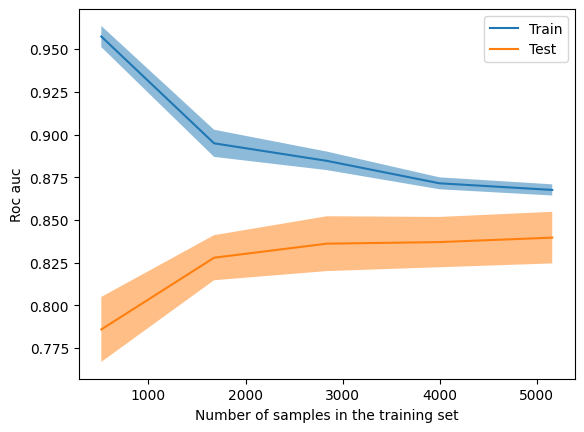

In [179]:
from sklearn.model_selection import LearningCurveDisplay

LearningCurveDisplay.from_estimator(best_model, X_train, y_train, scoring='roc_auc')

**Insight:**<br>
- ***Training Curve:*** The ROC-AUC values ​​on the training data tend to decrease as the number of samples increases. This indicates that the model becomes more complex as it is trained with more data, potentially memorizing the training data.
- ***Testing Curve:*** The ROC-AUC values ​​on the testing data tend to increase up to a certain point, then plateau. This indicates that the model initially learns more general features, and after reaching saturation, additional training data does not provide significant performance improvements on previously unseen data.
- ***Shaded Area:*** **The shaded area represents the uncertainty or variability in the ROC-AUC estimates. The narrower the area, the more consistent the results.**

**7.6 Model Calibration**

The plot shows the calibration of machine learning model. In essence, it assesses how well the predicted probabilities from model align with the actual observed frequencies of the positive class.<br>

- **Key Elements of the Plot:**
    - X-axis: Represents the mean predicted probability of the positive class.
    - Y-axis: Represents the fraction of positives observed in the data for a given predicted probability bin.

- **Perfect Calibration:**<br>
The black dotted line represents perfect calibration. This line indicates that if the model predicts a probability of 0.5 for the positive class, then exactly 50% of the instances in that predicted probability bin should actually belong to the positive class.

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


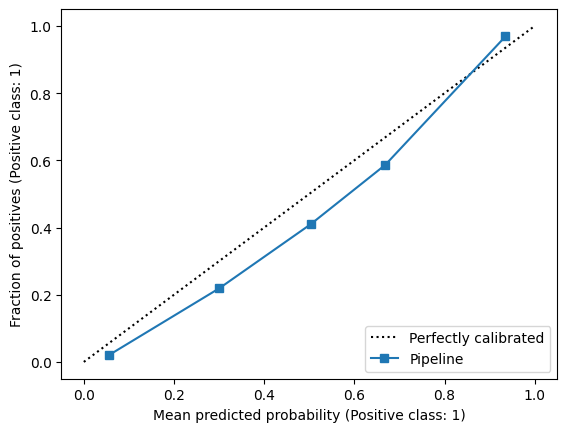

In [180]:
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV

CalibrationDisplay.from_estimator(best_model, X_train, y_train)

**Insight:**<br>

The first plot shows the best model calibration before recalibration. The blue line deviating from the black dotted line (representing a perfect model) indicates the model is not perfect at predicting the probability of the positive class. It’s possible that the model is:<br>

- Overconfident: The model is too confident in its predictions, so the probabilities given are either too high or too low compared to the actual frequency of the positive class.

- Unconfident: The model is too uncertain about its predictions, so the probabilities given tend to be somewhere in the middle.

In [181]:
clf_calibrated = CalibratedClassifierCV(best_model, cv='prefit')

In [182]:
clf_calibrated.fit(X_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


CalibratedClassifierCV(cv='prefit',
                       estimator=Pipeline(steps=[('FeatureEngineering',
                                                  ColumnTransformer(remainder='passthrough',
                                                                    transformers=[('scaling_minmax',
                                                                                   MinMaxScaler(),
                                                                                   ['total_of_special_requests']),
                                                                                  ('encoding_ohe',
                                                                                   OneHotEncoder(drop='first',
                                                                                                 handle_unknown='ignore'),
                                                                                   ['market_segment',
                                                                                    'deposit_type',
                                                                                    'customer_type',
                                                                                    'reserved_room_type']),
                                                                                  ('binary',
                                                                                   BinaryEncoder(),
                                                                                   ['country'])],
                                                                    verbose_feature_names_out=False)),
                                                 ('Resampling',
                                                  SMOTE(random_state=42)),
                                                 ('Classifier',
                                                  LGBMClassifier(learning_rate=0.05,
                                                                 max_bin=250,
                                                                 max_depth=10,
                                                                 min_data_in_leaf=30,
                                                                 num_iterations=225,
                                                                 num_leaves=10,
                                                                 random_state=42))]))

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


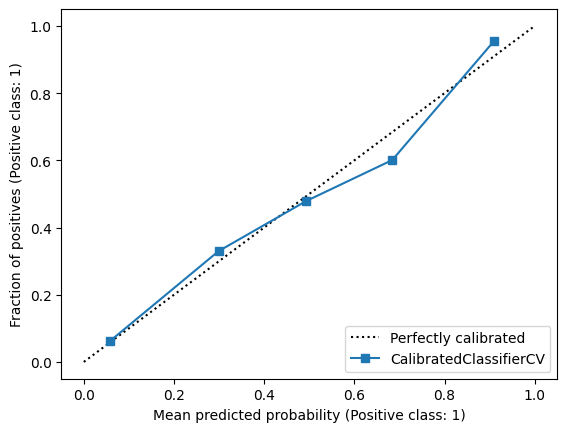

In [183]:
# Classifier after calibration
CalibrationDisplay.from_estimator(clf_calibrated, X_train, y_train)

**Insight:**<br>

Meanwhile, the second plot shows the model calibration after recalibration using CalibratedClassifierCV. The blue line in this plot is expected to be closer to the black dotted line, indicating that the model has been calibrated so that the given probabilities are more in line with the actual frequency of the positive class.

**7.7 Model Explanation and Interpretation**

- Feature Importance (Tree Based Model) -> LightGBM Model

In [184]:
model = clf_calibrated.estimator.named_steps['Classifier'] # Get the model
preprocessing = clf_calibrated.estimator.named_steps['FeatureEngineering'] # Get preprocessor

In [185]:
feature_name = preprocessing.get_feature_names_out()
score = model.feature_importances_

In [186]:
feat_imp = pd.DataFrame({
    'feature': feature_name,
    'importance': score
}).sort_values('importance', ascending=False)

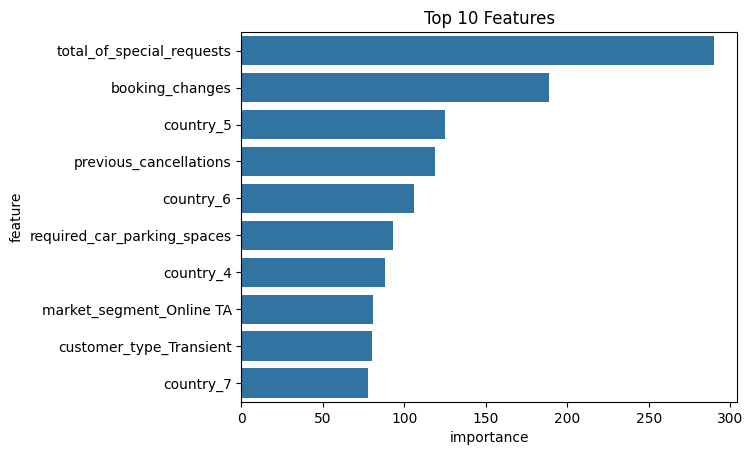

In [187]:
result = pd.DataFrame({'feature': feature_name, 'importance': score}).sort_values('importance', ascending=False).head(10)
sns.barplot(result, x='importance', y='feature')
plt.title("Top 10 Features")
plt.show()

**Insight:**<br>

- ***total_of_special_requests:*** This feature has the most significant impact on the prediction results. It shows that the number of special requests submitted by customers is highly related to the predicted target variable.
- ***booking_changes:*** This feature also has a significant impact. It indicates that the frequency of booking changes can be an important indicator in predicting certain outcomes.

- SHAP Value identification

In [188]:
import shap

In [189]:
shap.initjs()

In [190]:
model = clf_calibrated.estimator.named_steps['Classifier']
preprocessor = clf_calibrated.estimator.named_steps['FeatureEngineering']

X_train_pre = preprocessor.transform(X_train)
X_train_pre_df = pd.DataFrame(X_train, columns=preprocessor.get_feature_names_out())

X_test_pre = preprocessor.transform(X_test)
X_test_pre_df = pd.DataFrame(X_test_pre, columns=preprocessor.get_feature_names_out())

In [191]:
explainer = shap.TreeExplainer(model=model,
                                 data=X_train_pre_df,
                                 model_output="probability",
                                 feature_names=preprocessor.get_feature_names_out())

In [192]:
shap_values = explainer.shap_values(X_train_pre)

 97%|=================== | 6251/6448 [00:24<00:00]       

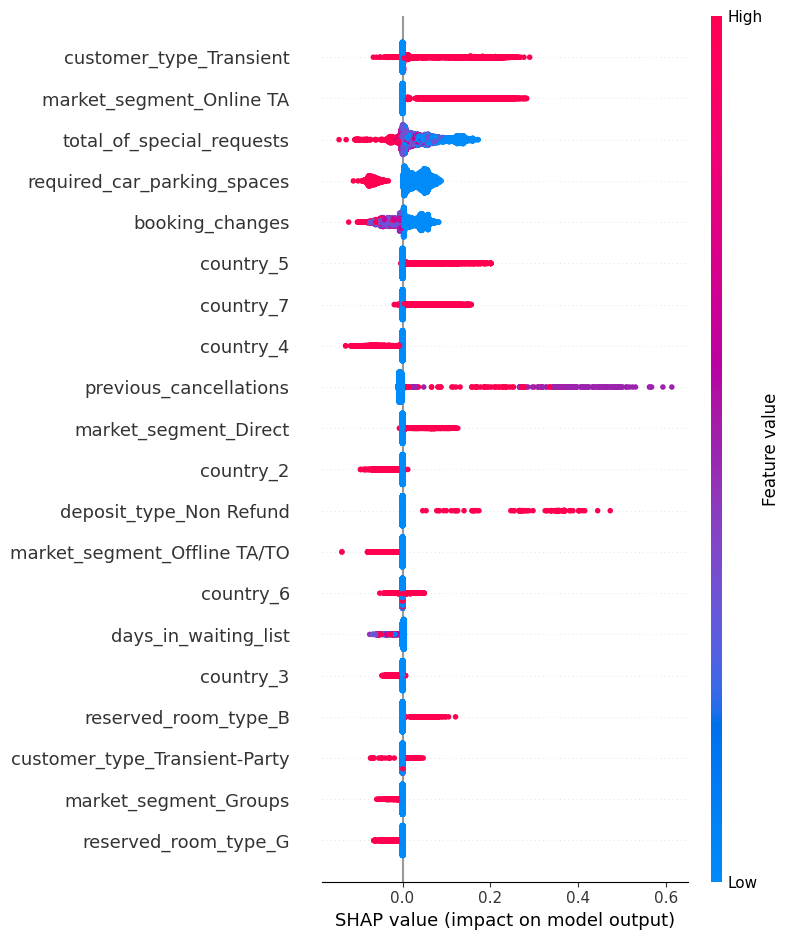

In [193]:
shap.summary_plot(shap_values, X_train_pre, feature_names=preprocessor.get_feature_names_out())

**Insight:**<br>

- total_of_special_requests, booking_changes, and required_car_parking_spaces have a very large impact on the prediction. The dots on these features tend to be red, indicating that increasing the value of these features will increase the prediction value.
- Country-related features (country_5, country_4, country_7, etc.) also have a significant impact. This indicates that the country of origin of the customer has a strong influence on the behavior or characteristics being predicted.
- Customer type and market segment-related features such as customer_type_Transient, market_segment_Online TA, and market_segment_Direct also make a significant contribution. This indicates that the type of customer and how they make reservations have an impact on the prediction results.

- Counter Factual Analysis

## **Section 8. Model Deployment**

In [194]:
best_model.fit(feature, target)
pickle.dump(best_model, open("LGBM-final-clf_calibrated-084.sav", 'wb'))

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Info] Number of positive: 6148, number of negative: 6148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001176 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3077
[LightGBM] [Info] Number of data points in the train set: 12296, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


## **Section 9. Model Implementation**

**9.1 How to implement the model ?**


**9.2 What are the limitations of the model ?**

**9.3 Business Calculation (Simulation using unseen data)**

## **Section 10. Conclusion and Recommendation**

**10.1 Conclusion**
- Conclusion (Model)
- Conclusion (Business)

**10.2 Recommendation**
- Recommendation (Model)
- Recommendation (Business)